In [16]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

In [17]:
# read data

df = pd.read_csv('all_task_environments.csv', header=0, skiprows=[1])

In [21]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,]):
    ''' Predicts sequence based on required objects, object coordinates, start coordinates of subject,
        parameters (c+k) and dimensionality.
        Input: Objects, object coordinates, start coordinates, c, k, dimension
        Output: Sequence of objects as str
    '''
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        prediction.append(minval)
        del possible_items[minval]
        coord_index += 1
        
    return prediction

In [20]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence):
    ''' Returns average edit distance (Damerau-Levenshtein) for 100 trials of sequence prediction.
    '''
    edit_list = []

    for x in range(0,100):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    avg = np.mean(edit_list)
    return avg

In [22]:
def get_avg_editdist(data):
    ''' Calculates average edit distance for all combinations of parameters (c, k, dimension).
        Input: Dataframe with objects, coordinates, start coordinates, object categories
        Output: Dataframe with edit distance results (col name: parameters used)
    '''
    results = pd.DataFrame()
    dimensions = [[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']]
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        #for k in np.arange(0.0,1.0,0.1):
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.0,2.0,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    #params = 'c: ' + str(c) + ', k: ' + str(k_strong) + ',' + str(k_mid) + ', dim: ' + str(dim[1])
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results

#TODO:
# range for diff between strong/mid k?
# range for c and k in general?

In [7]:
#%%timeit -n1 -r1
results_new = get_avg_editdist(df)

In [8]:
results_new

,"c: 1.0; k: 0.0,0.1; x","c: 1.0; k: 0.0,0.1; y","c: 1.0; k: 0.0,0.1; z","c: 1.0; k: 0.0,0.1; xy","c: 1.0; k: 0.0,0.1; xz","c: 1.0; k: 0.0,0.1; yz","c: 1.0; k: 0.0,0.1; xyz","c: 1.1; k: 0.0,0.1; x","c: 1.1; k: 0.0,0.1; y","c: 1.1; k: 0.0,0.1; z",...,"c: 1.8; k: 0.8,0.9; xz","c: 1.8; k: 0.8,0.9; yz","c: 1.8; k: 0.8,0.9; xyz","c: 1.9; k: 0.8,0.9; x","c: 1.9; k: 0.8,0.9; y","c: 1.9; k: 0.8,0.9; z","c: 1.9; k: 0.8,0.9; xy","c: 1.9; k: 0.8,0.9; xz","c: 1.9; k: 0.8,0.9; yz","c: 1.9; k: 0.8,0.9; xyz"
0,0.410000,0.876000,0.702000,0.300000,0.198000,0.400000,0.000000,0.190000,0.628000,0.706000,...,0.298000,0.400000,0.200000,0.210000,0.454000,0.448000,0.094000,0.294000,0.400000,0.200000
1,0.408000,0.600000,0.714000,0.200000,0.330000,0.600000,0.200000,0.186000,0.600000,0.714000,...,0.500000,0.600000,0.400000,0.224000,0.600000,0.534000,0.400000,0.504000,0.600000,0.400000
2,0.406000,0.600000,0.710000,0.000000,0.212000,0.600000,0.000000,0.192000,0.600000,0.692000,...,0.292000,0.400000,0.200000,0.168000,0.400000,0.458000,0.200000,0.310000,0.400000,0.200000
3,0.540000,0.400000,0.400000,0.200000,0.318000,0.400000,0.200000,0.406000,0.400000,0.400000,...,0.108000,0.200000,0.000000,0.390000,0.200000,0.254000,0.000000,0.106000,0.200000,0.000000
4,0.356667,0.666667,0.666667,0.500000,0.333333,0.666667,0.333333,0.000000,0.666667,0.333333,...,0.000000,0.510000,0.333333,0.000000,0.530000,0.160000,0.526667,0.000000,0.503333,0.333333
5,0.704000,0.500000,0.800000,0.584000,0.400000,0.298000,0.400000,0.694000,0.312000,0.800000,...,0.400000,0.800000,0.800000,0.648000,0.400000,0.800000,0.604000,0.400000,0.800000,0.800000
6,0.812500,0.717500,0.835000,1.000000,0.755000,1.000000,1.000000,0.745000,0.695000,0.770000,...,0.725000,0.500000,0.500000,0.750000,0.500000,0.775000,0.500000,0.690000,0.500000,0.500000
7,0.735000,1.000000,0.695000,1.000000,0.785000,1.000000,1.000000,1.000000,1.000000,0.715000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.730000,1.000000,1.000000,1.000000,1.000000
8,0.170000,0.320000,0.476667,0.000000,0.150000,0.300000,0.000000,0.163333,0.280000,0.426667,...,0.186667,0.326667,0.000000,0.160000,0.246667,0.416667,0.000000,0.143333,0.280000,0.000000
9,0.163333,0.506667,0.150000,0.333333,0.150000,0.333333,0.333333,0.150000,0.493333,0.186667,...,0.140000,0.333333,0.333333,0.150000,0.503333,0.196667,0.333333,0.173333,0.333333,0.333333


In [23]:
def get_lowest_error(results):
    ''' Returns lowest error in dataframe and index of lowest error.
    '''
    for col in list(results):
        results.loc['mean',col] = results[col].mean()
    lowest = min(results.loc['mean'])
    mean = sorted(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [10]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.4142824074074074, Index(['c: 1.5; k: 0.2,0.3; xy'], dtype='object'))

In [24]:
# Compare avg edit distance for xy and xyz
list_xy = []
list_xyz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'xy':
        list_xy.append(results_mean.at['mean',col])
        
avg_xy = np.mean(list_xy)
print('Average xy: ' + str(avg_xy))

for col in results_mean:
    if col.split(';')[2].strip() == 'xyz':
        list_xyz.append(results_mean.at['mean',col])
        
avg_xyz = np.mean(list_xyz)
print('Average xyz: ' + str(avg_xyz))

Average xy: 0.44737069003527336
Average xyz: 0.4528397523515579


In [25]:
# Compare avg edit distances for x, y, z
list_x = []
list_y = []
list_z = []

for col in results_mean:
    if col.split(';')[2].strip() == 'x':
        list_x.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'y':
        list_y.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'z':
        list_z.append(results_mean.at['mean',col])
        
avg_x = np.mean(list_x)
print('Average x: ' + str(avg_x))      
        
avg_y = np.mean(list_y)
print('Average y: ' + str(avg_y)) 
        
avg_z = np.mean(list_z)
print('Average z: ' + str(avg_z))

Average x: 0.5010550852439741
Average y: 0.5321387970311581
Average z: 0.5949652851263962


In [45]:
spearmanr(list_z, list_x)

SpearmanrResult(correlation=0.23909947730172446, pvalue=0.023230881695919907)

In [26]:
# Define input for figures

c = [float(x[3:6]) for x in results_new.columns.tolist()]
k = [float(x[11:14]) for x in results_new.columns.tolist()]
dim = [x.strip() for x in results_new.columns.str.split(';').str[2]]
error = results_mean.loc['mean'].tolist()

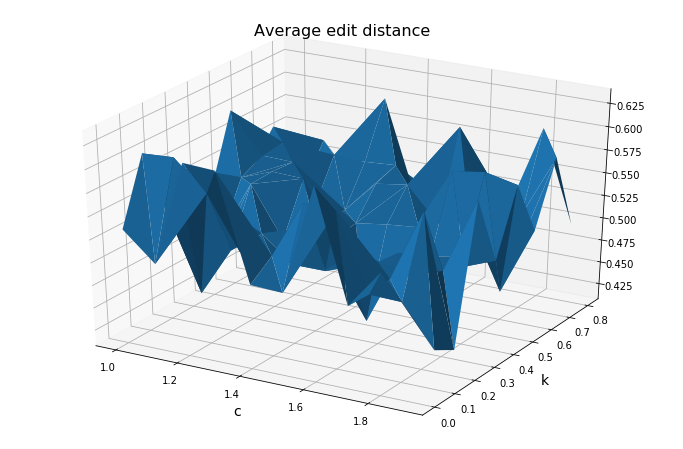

In [12]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c, k, error, linewidth=0.2)
ax.set_ylabel('k', fontsize=14, labelpad=7)
ax.set_xlabel('c', fontsize=14, labelpad=7)
plt.title('Average edit distance', fontsize=16)
plt.show()

In [13]:
%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot
img = ax2.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# set labels
ax2.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax2.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax2.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)
plt.title('Average edit distance (1 step)', fontsize=16)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks)
plt.show()

In [15]:
# generate rotating image

fig3 = plt.figure(figsize=(12,8))
ax3 = mplot3d.Axes3D(fig3)
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax3.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax3.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)

def init():
    ax3.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)
    
    return fig,

def animate(i):
    ax3.view_init(elev=10, azim=i*4)
    return fig,

animated = animation.FuncAnimation(fig3, animate, init_func=init, frames=90, interval=50, blit=True)

In [284]:
# save animated fig

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fig_name = 'rotate_model_lowesterror_3D'
#animated.save(fig_name+'.gif', writer='imagemagick', fps=1000/50)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=10000)
animated.save(fig_name+'.mp4', writer=writer)